In [45]:
%load_ext autoreload
%autoreload 2

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.optimize import minimize

import data_utils
import plots
import truncated_normal, normal
import deltas
import projection
import radius

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


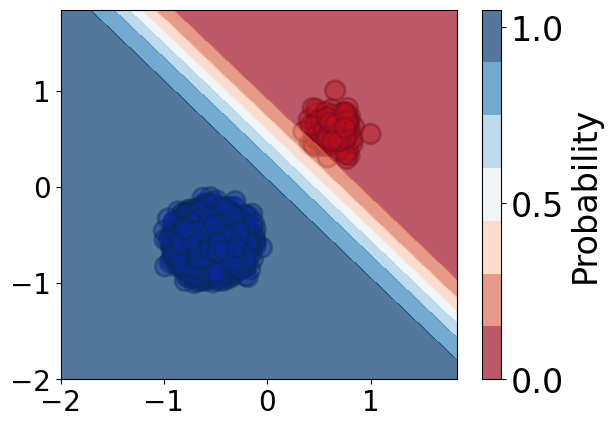

In [46]:
m1 = [1, 1]
m2 = [10, 10]

cov1 = [[1, 0], [0, 1]]
cov2 = [[5, 0], [0, 5]]
cov2 = cov1

N1 = 10000
N2 = 100
scale = True

data = normal.get_two_classes(means=[m1, m2], 
                              covs=[cov1, cov2],
                              num_samples=[N1, N2])
scaler = data_utils.normaliser(data)
if scale == True:
    data = scaler(data)
    m1 = scaler.transform_instance(m1)
    m2 = scaler.transform_instance(m2)

clf = SVC(random_state=0, probability=True,
          kernel='linear').fit(data['X'], data['y'])

clf = LogisticRegression().fit(data['X'], data['y'])

ax, _ = plots._get_axes(None)
plots.plot_classes(data, ax=ax)
plots.plot_decision_boundary(clf, data, ax=ax)
plots.plt.show()

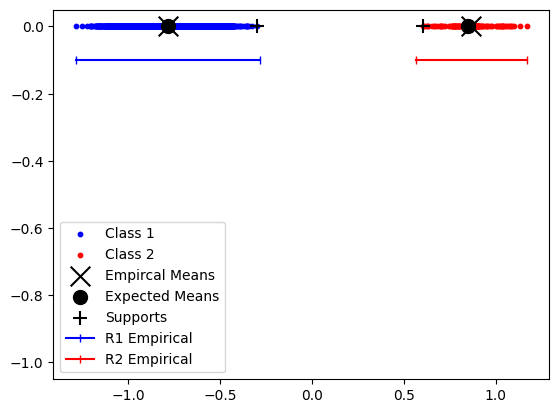

In [47]:
# get projections
import radius
proj_data = projection.from_clf(data, clf, supports=True)
proj_means = projection.from_clf({'X': np.array([m1, m2]), 'y': [0, 1]}, clf)

# Empircal M
M_emp = np.abs(proj_data['supports'][1]-proj_data['supports'][0]).squeeze()

# get Rs
R_sup = radius.supremum(data['X'])
R_sup = radius.supremum(proj_data['X'])
# empirical means
xp1, xp2 = projection.get_classes(proj_data)
emp_xp1, emp_xp2 = projection.get_emp_means(proj_data)
R1_emp = radius.supremum(proj_data['X1'], emp_xp1)
R2_emp = radius.supremum(proj_data['X2'], emp_xp2)

# plot
ax = plots.plot_projection(proj_data, proj_means, R1_emp, R2_emp)

In [48]:
# Optimise Eq. 6 using the constraint eq. 9
c1 = 1
c2 = 1
bounds = [(0, 1)]
delta1_init = (0.5)
delta1_init = (np.random.uniform())

use_grad = True
if use_grad == True:
    func = deltas.scipy_optim_func
else:
    func = deltas.loss_one_delta
res = minimize(func,
               delta1_init,
               (c1, c2, N1, N2, M_emp, R_sup), 
               # method='CG', 
               bounds=bounds,
               jac=use_grad,  # use gradient
               )
delta1 = res.x
delta2 = deltas.delta2_given_delta1(N1, N2, M_emp, delta1, R_sup)
print(f'delta1 : {delta1} \ndelta2: {delta2}')

delta1 : [0.07185433] 
delta2: [0.07322279]


c:\Users\mattc\PhD\linear_confidence\deltas.py:38: RuntimeWarning: divide by zero encountered in divide
  ((1/(N1*delta1)) * (1/(np.sqrt((2*np.log(1/delta1))/N1))))


R1 : [0.61222925] 
R2: [1.4055351]


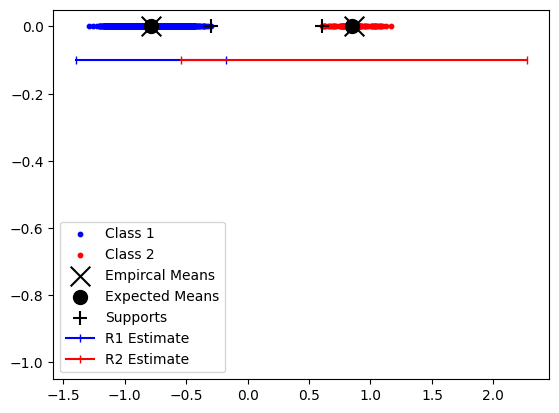

In [49]:
# calculate each R upper bound
R1_est = radius.R_upper_bound(R1_emp, R_sup, N1, delta1)
R2_est = radius.R_upper_bound(R2_emp, R_sup, N2, delta2)
print(f'R1 : {R1_est} \nR2: {R2_est}')
ax = plots.plot_projection(proj_data, proj_means, R1_est, R2_est, R_est=True)